In [255]:
import lvm_read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from sympy import I, Eq, Abs, N
from numpy import pi
from scipy.optimize import curve_fit, minimize_scalar

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 24})


In [256]:
width = 7
figsize=(width, width*3/4)

# Lettura file

In [257]:
def read_file(filename, columns):
    file_lvm = lvm_read.read(filename, read_from_pickle=False)
    return pd.DataFrame(file_lvm[0]['data'], columns=columns)


In [258]:
noise_df = read_file('../data/Noise.lvm', ['time', 'V_S'])
frequency_noise_df = read_file('../data/frequency-noise/V_S_sweep.lvm', ['frequency', 'amplitude', 'phase'])
variable_frequency_noise_df = read_file('../data/frequency-noise/amp-phase-200k/V_S_sweep.lvm', ['frequency', 'amplitude', 'phase'])


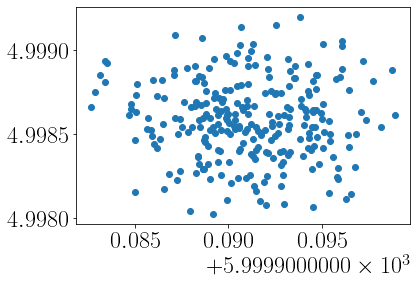

In [259]:
plt.scatter((frequency_noise_df[frequency_noise_df['phase']<0.3])['frequency'],
            (frequency_noise_df[frequency_noise_df['phase']<0.3])['amplitude'])


In [260]:
signals_df = read_file('../data/Signals.lvm', ['time', 'V_S', 'V_T', 'V_W'])

filter_500_df = read_file('../data/Filter500.lvm', ['time', 'V_S', 'V_T', 'V_W'])
filter_1905_df = read_file('../data/Filter1905.lvm', ['time', 'V_S', 'V_T', 'V_W'])
filter_8000_df = read_file('../data/Filter8000.lvm', ['time', 'V_S', 'V_T', 'V_W'])


In [261]:
V_S_sweep_df = read_file('../data/sweeps/V_S_sweep.lvm', ['frequency', 'amplitude', 'phase'])
V_T_sweep_df = read_file('../data/sweeps/V_T_sweep.lvm', ['frequency', 'amplitude', 'phase'])
V_W_sweep_df = read_file('../data/sweeps/V_W_sweep.lvm', ['frequency', 'amplitude', 'phase'])

# Calcolo errori

In [262]:
voltage_offset = noise_df['V_S'].mean() - 0.5
voltage_error = noise_df['V_S'].std()

frequency_offset = frequency_noise_df['frequency'].mean() - 6000
frequency_error = frequency_noise_df['frequency'].std()

amplitude_offset = frequency_noise_df['amplitude'].mean() - 5
amplitude_error = frequency_noise_df['amplitude'].std()

phase_offset = frequency_noise_df['phase'].mean()
phase_error = frequency_noise_df['phase'].std()


In [310]:
phase_error

0.05220427052054965

# Errori sistematici sugli sweep
V_S_sweep_df['frequency'] -= frequency_offset
V_T_sweep_df['frequency'] -= frequency_offset
V_W_sweep_df['frequency'] -= frequency_offset

V_S_sweep_df['amplitude'] -= amplitude_offset
V_T_sweep_df['amplitude'] -= amplitude_offset
V_W_sweep_df['amplitude'] -= amplitude_offset

V_S_sweep_df['phase'] -= phase_offset
V_T_sweep_df['phase'] -= phase_offset
V_W_sweep_df['phase'] -= phase_offset

# Segnali di prova per il circuito

In [264]:
def plot_signals(df, title, lw=0.8):
    cm = 1/2.54
    fig = plt.figure(figsize=figsize)

    axes = fig.add_axes([0,0,1,1])

    axes.plot(df['time'], df['V_S'], label=r'$V_{in}$', lw=lw)
    axes.plot(df['time'], df['V_T'], label=r'$V_T$', lw=lw)
    axes.plot(df['time'], df['V_W'], label=r'$V_W$', lw=lw)
    axes.margins(x=0)
    axes.set_xlabel('Tempo (s)')
    axes.set_ylabel('Tensione (V)')
    axes.set_title(title)

    axes.legend(loc='upper right')
    axes.grid()


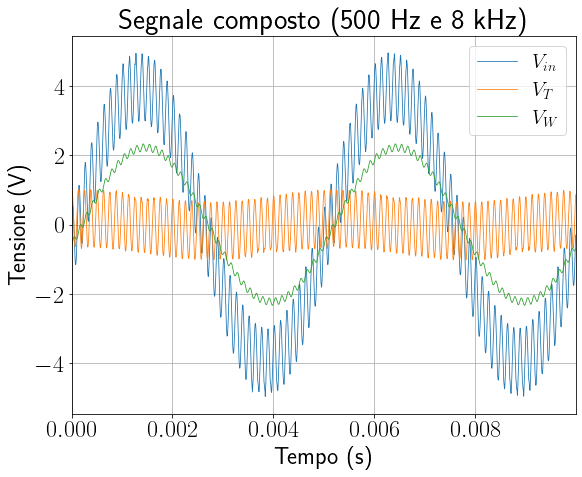

In [265]:
plot_signals(signals_df, 'Segnale composto (500 Hz e 8 kHz)')

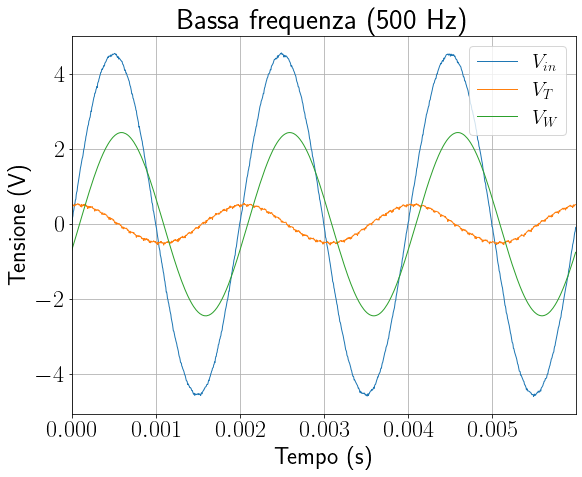

In [266]:
plot_signals(filter_500_df, 'Bassa frequenza (500 Hz)', 1)

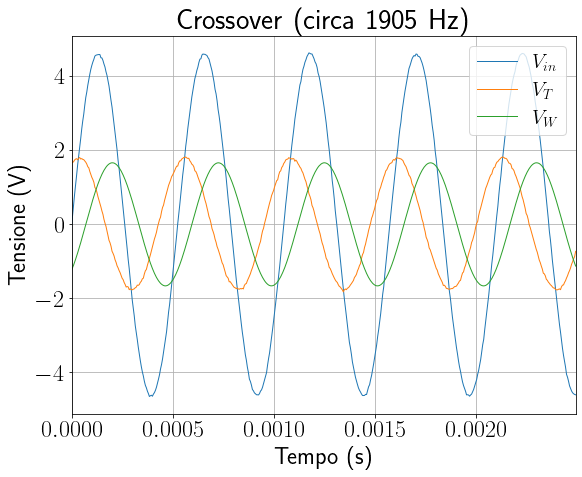

In [267]:
plot_signals(filter_1905_df, 'Crossover (circa 1905 Hz)', 1)

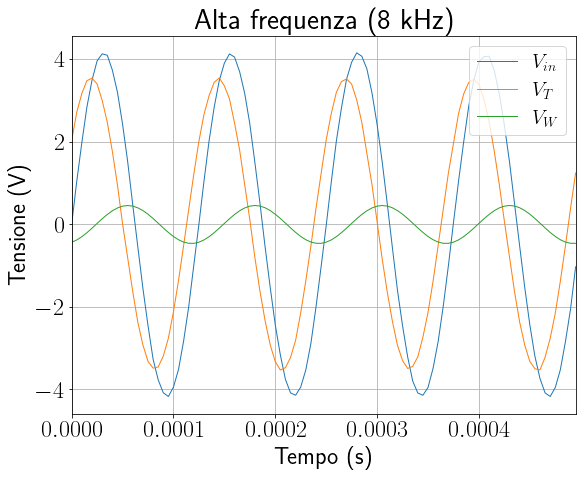

In [268]:
plot_signals(filter_8000_df, 'Alta frequenza (8 kHz)', 1)

# Espressioni simboliche

In [269]:
# Simulazione del circuito
R_int, R_L, R_W, R_C, R_T = sp.symbols('R_{int} R_L R_W R_C R_T', real=True, positive=True)
L, C, w, V_0, t = sp.symbols('L C \omega V_0 t', real=True, positive=True)

V = V_0*sp.exp(I*w*t)

Z_T = R_C + R_T + 1/(C*w*I)
Z_W = R_L + R_W + L*w*I
Z_eq = 1/(1/Z_T+1/Z_W)
Z_tot = Z_eq + R_int
i = V / Z_tot
V_eq = i * Z_eq
i_T = V_eq / Z_T
i_W = V_eq / Z_W

V_T = sp.simplify(i_T * R_T)
V_W = sp.simplify(i_W * R_W)

A_T = Abs(V_T.subs({t: 0}))
A_W = Abs(V_W.subs({t: 0}))

phi_T = sp.arg(V_T.subs({t: 0}))
phi_W = sp.arg(V_W.subs({t: 0}))


# Calcolo valori numerici

In [270]:
numerical_values = {
    R_int: 50, R_L: 203, R_W: 269.27, R_C: 0, R_T: 471.72,
    L: 46.79 * 10**-3, C: 70 * 10**-9, V_0: 5
}
uncertainties = {
    R_L: 0.19135, R_W: 0.22117, R_T: 0.312274, L: 0.4679 * 10**-3, C: 0.7 * 10**-9
}

In [271]:
def calculate_uncertainty(Y, f = w/(2*sp.pi), uncerts=uncertainties):
    sum = 0
    for x in uncertainties.keys():
        fixed_values = numerical_values.copy()
        x_value = fixed_values.pop(x)
        sum += ((N(Y.subs(fixed_values).diff(x).subs({x: x_value, w: 2*sp.pi*f}))) * uncerts[x]) ** 2
    return sp.sqrt(sum)


In [272]:
crossover_w = (sp.solve(Eq(Abs(Z_T), Abs(Z_W)), w))[1] # 2 solutions: the last is positive
crossover_freq = crossover_w / (2*sp.pi)
crossover_freq_val = N(crossover_freq.subs(numerical_values))
crossover_freq_err_val = calculate_uncertainty(crossover_freq, crossover_freq_val)
print('crossover_frequency (Hz) = ')
print(crossover_freq_val, ' +/- ', crossover_freq_err_val)


crossover_frequency (Hz) = 
2780.41905174074  +/-  19.6650183012760


In [273]:
crossover_w / (2*sp.pi)

sqrt(2)*sqrt(C*R_C**2 + 2*C*R_C*R_T - C*R_L**2 - 2*C*R_L*R_W + C*R_T**2 - C*R_W**2 + sqrt(C**2*R_C**4 + 4*C**2*R_C**3*R_T - 2*C**2*R_C**2*R_L**2 - 4*C**2*R_C**2*R_L*R_W + 6*C**2*R_C**2*R_T**2 - 2*C**2*R_C**2*R_W**2 - 4*C**2*R_C*R_L**2*R_T - 8*C**2*R_C*R_L*R_T*R_W + 4*C**2*R_C*R_T**3 - 4*C**2*R_C*R_T*R_W**2 + C**2*R_L**4 + 4*C**2*R_L**3*R_W - 2*C**2*R_L**2*R_T**2 + 6*C**2*R_L**2*R_W**2 - 4*C**2*R_L*R_T**2*R_W + 4*C**2*R_L*R_W**3 + C**2*R_T**4 - 2*C**2*R_T**2*R_W**2 + C**2*R_W**4 + 4*L**2))/(4*pi*sqrt(C)*L)

In [274]:
crossover_amplitude = Abs(A_T).subs({w: crossover_w})
crossover_amplitude_val = N(crossover_amplitude.subs(numerical_values))
crossover_amplitude_err_val = calculate_uncertainty(crossover_amplitude, crossover_amplitude_val)
print('crossover amplitude (V) = ')
print(crossover_amplitude_val, ' +/- ', crossover_amplitude_err_val)

crossover amplitude (V) = 
2.37275210371565  +/-  0.0114005869566380


In [275]:
amplitude_match_w = (sp.solve(Eq(A_T, A_W), w))[1]
amplitude_match_freq = amplitude_match_w / (2 * sp.pi)
amplitude_match_freq_val = N(amplitude_match_freq.subs(numerical_values))
amplitude_match_freq_err_val = calculate_uncertainty(amplitude_match_freq, amplitude_match_freq_val)
print('amplitude match frequency (Hz) = ')
print(amplitude_match_freq_val, ' +/- ', amplitude_match_freq_err_val)


amplitude match frequency (Hz) = 
1904.95499898197  +/-  13.7670798271292


In [276]:
match_amplitude = Abs(A_T).subs({w: amplitude_match_w})
match_amplitude_val = N(match_amplitude.subs(numerical_values))
match_amplitude_err_val = calculate_uncertainty(match_amplitude, match_amplitude_val)
print('match amplitude (V) = ')
print(match_amplitude_val, ' +/- ', match_amplitude_err_val)

match amplitude (V) = 
1.73633551912144  +/-  0.00766222446366372


In [277]:
'''Da circuito ideale'''
phi_match_w_theory = sp.sqrt((R_L+R_W) / (C*L * (R_C+R_T)))
phi_match_freq_theory = phi_match_w_theory / (2*pi)
phi_match_freq_theory_val = N(phi_match_freq_theory.subs(numerical_values))
phi_match_freq_theory_err_val = calculate_uncertainty(phi_match_freq_theory, phi_match_freq_theory_val)
print('phase match frequency (Hz) = ')
print(phi_match_freq_theory_val, ' +/- ', phi_match_freq_theory_err_val)

phase match frequency (Hz) = 
2782.57977068268  +/-  19.7161883951556


In [278]:
# Remove bad points in frequency analysis
"""
to_drop = []
for i in range(1, V_S_sweep_df.shape[0] - 1):
    if (abs(V_S_sweep_df.loc[i, 'amplitude'] - (V_S_sweep_df.loc[i-1, 'amplitude'] + V_S_sweep_df.loc[i+1, 'amplitude']) / 2) > 0.05):
        to_drop.append(i)
for i in to_drop:
    V_S_sweep_df.drop(i, inplace=True)
    V_T_sweep_df.drop(i, inplace=True)
    V_W_sweep_df.drop(i, inplace=True)
"""

"\nto_drop = []\nfor i in range(1, V_S_sweep_df.shape[0] - 1):\n    if (abs(V_S_sweep_df.loc[i, 'amplitude'] - (V_S_sweep_df.loc[i-1, 'amplitude'] + V_S_sweep_df.loc[i+1, 'amplitude']) / 2) > 0.05):\n        to_drop.append(i)\nfor i in to_drop:\n    V_S_sweep_df.drop(i, inplace=True)\n    V_T_sweep_df.drop(i, inplace=True)\n    V_W_sweep_df.drop(i, inplace=True)\n"

# Previsione teorica ampiezza

In [279]:
plt.rc('legend',fontsize=20)

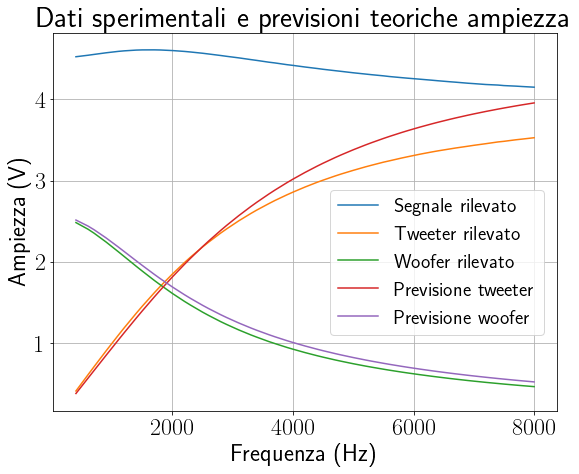

In [280]:
fig = plt.figure(figsize=figsize)

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Dati sperimentali e previsioni teoriche ampiezza')

axes.plot(V_S_sweep_df['frequency'], V_S_sweep_df['amplitude'], label='Segnale rilevato')
axes.plot(V_T_sweep_df['frequency'], V_T_sweep_df['amplitude'], label='Tweeter rilevato')
axes.plot(V_W_sweep_df['frequency'], V_W_sweep_df['amplitude'], label='Woofer rilevato')

"""
A_Ts = np.array([N(A_T.subs({w: 2*pi*V_T_sweep_df.loc[i,'frequency'], V_0: V_S_sweep_df.loc[i,'amplitude']}).subs(numerical_values)) for i in V_T_sweep_df.index.tolist()])
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Previsione tweeter')

A_Ws = np.array([N(A_W.subs({w: 2*pi*V_W_sweep_df.loc[i,'frequency'], V_0: V_S_sweep_df.loc[i,'amplitude']}).subs(numerical_values)) for i in V_W_sweep_df.index.tolist()])
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Previsione woofer')

"""
A_Ts = np.array([N(A_T.subs({w: 2*pi*V_T_sweep_df.loc[i,'frequency']}).subs(numerical_values)) for i in V_T_sweep_df.index.tolist()])
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Previsione tweeter')

A_Ws = np.array([N(A_W.subs({w: 2*pi*V_W_sweep_df.loc[i,'frequency']}).subs(numerical_values)) for i in V_W_sweep_df.index.tolist()])
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Previsione woofer')


"""
boosted_woofer = A_Ws / numerical_values[R_W] * (numerical_values[R_W] + numerical_values[R_L])
axes.plot(V_W_sweep_df['frequency'], boosted_woofer, label='Woofer ideale')
"""

axes.legend(loc=(0.55, 0.2))
axes.grid()


# Funzioni python per fit

In [281]:
def substitute_except(expr, syms):
    new_num_values = { key: numerical_values[key] for key in numerical_values if key not in syms }
    new_expr = expr.subs(new_num_values)
    return new_expr

    
def compute_chi_square(xdata: pd.Series, ydata, fit_func_lambda, yerr, xerr=0, fit_func=None, ind_var=None):
    if yerr == 0: return np.Infinity
    s = 0
    deriv = sp.lambdify(ind_var, fit_func.diff(ind_var))
    for i in xdata.index.values.tolist():
        x = xdata[i]
        y = ydata[i]
        y_fit = fit_func_lambda(x)
        err = yerr
        if xerr > 0:
            deriv_err = xerr * deriv(x)
            err = np.sqrt(yerr**2 + deriv_err**2)
        s += (y - y_fit)**2 / err**2
    return s

def compute_rms(xdata, ydata, fit_func_lambda):
    s = 0
    for i in xdata.index.values.tolist():
        x = xdata[i]
        y = ydata[i]
        y_fit = fit_func_lambda(x)
        s += (y - y_fit)**2
    return np.sqrt(s / (xdata.count() - 1))

def fit(expr, ind_var, params, x, y, yerr=0, xerr=0, p0={}):
    func_parameters = [ind_var] + params
    initial_values = []
    for param in params:
        initial_values.append((numerical_values | p0)[param])
    new_func = substitute_except(expr, func_parameters)
    to_fit = sp.lambdify(func_parameters, new_func)
    parameters, covariance = curve_fit(to_fit, x, y, p0=initial_values)
    par_errors = [np.sqrt(covariance[i, i]) for i in range(len(params))]
    new_values = {}
    for i in range(len(params)):
        new_values[params[i]] = parameters[i]
    dict_params = dict(zip(params, parameters))
    dict_par_errors = dict(zip(params, par_errors))
    fit_func = new_func.subs(new_values)
    fit_func_lambda = sp.lambdify(ind_var, fit_func)
    if yerr > 0:
        chi_square = compute_chi_square(x, y, fit_func_lambda, yerr, xerr, fit_func, ind_var)
        dof = x.count() - len(params)
        print('parameters = ', parameters)
        print('chi square / dof = ', chi_square, ' / ', dof)
    print('par errors = ')
    print(par_errors)
    return fit_func_lambda, dict_params, dict_par_errors



# Fit ampiezza

In [282]:
df = variable_frequency_noise_df
a, b, c = sp.symbols('a b c')
quad_w = a*w**2+b*w+c

In [283]:
quad_w_fit, quad_w_p0, _ = fit(quad_w, w, [a, b, c], df['frequency'], df['amplitude'], p0={a: 10**-3, b: 10**4, c: 0.1})


par errors = 
[3.5784475970702945e-12, 3.082361988198624e-08, 5.627391068007472e-05]


Text(0.5, 1.0, "Andamento dell'ampiezza in funzione della frequenza")

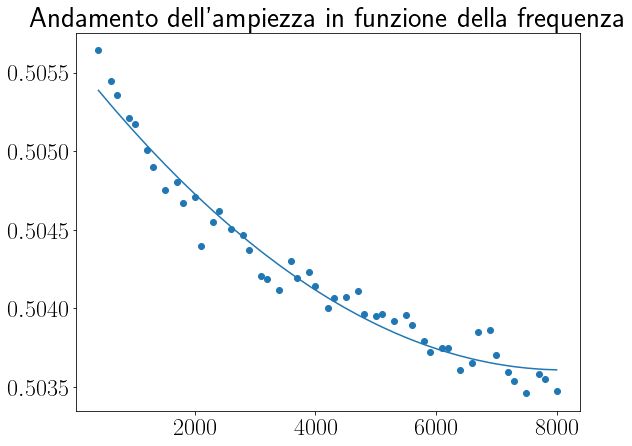

In [284]:
fig = plt.figure(figsize=figsize)

axes = fig.add_axes([0,0,1,1])

axes.scatter(df['frequency'], df['amplitude'])
axes.plot(df['frequency'], df['frequency'].apply(quad_w_fit))
axes.set_title('Andamento dell\'ampiezza in funzione della frequenza')

In [285]:
quad_w_error = compute_rms(df['frequency'], df['amplitude'], quad_w_fit)

In [286]:
A_T_fit, A_T_fit_params, A_T_fit_par_errors = fit(A_T + quad_w, w, [C, L, R_L, R_int, a, b, c], V_T_sweep_df['frequency'].apply(lambda f: 2*pi*f), V_T_sweep_df['amplitude'], yerr=amplitude_error, xerr=frequency_error, p0=quad_w_p0)

parameters =  [ 7.03936801e-08  2.50674532e-01  1.84968877e+03  1.78115204e+02
 -4.32597425e-11  6.01553891e-06  7.12910717e-03]
chi square / dof =  306.73386819138403  /  42
par errors = 
[4.1585956544667063e-10, 0.009939071304971504, 124.45835840327001, 10.415893888288862, 1.4831111806378733e-11, 1.7194097470636421e-06, 0.0027868182128415464]


In [287]:
A_W_fit, A_W_fit_params, A_W_fit_par_errors = fit(A_W + quad_w, w, [C, L, R_L, R_int, a, b, c], V_W_sweep_df['frequency'].apply(lambda f: 2*pi*f), V_W_sweep_df['amplitude'], yerr=amplitude_error, xerr=frequency_error, p0=quad_w_p0)

parameters =  [ 6.29631468e-08  5.64931276e-02  1.25004403e+02  1.80569819e+02
  2.00822909e-11 -3.46861898e-06  2.16307184e-01]
chi square / dof =  21.328388282038397  /  42
par errors = 
[2.406835248177267e-09, 0.0010361827674211963, 11.114636398783487, 15.611690321677958, 3.856889288664036e-12, 4.997629616524489e-07, 0.026533781114156375]


In [288]:
from scipy.optimize import minimize_scalar
crossover_w_fit = minimize_scalar(lambda wx: (A_T_fit(wx) - A_W_fit(wx))**2, bounds=(1500*2*np.pi, 2000*2*np.pi), method='bounded')
crossover_freq_fit = crossover_w_fit.x / 2 / pi
crossover_freq_err_val = calculate_uncertainty(crossover_freq, crossover_freq_fit, uncertainties | A_W_fit_par_errors)
print('crossover dal fit (Hz) = ')
print(crossover_freq_fit, ' +/- ', crossover_freq_err_val)

crossover dal fit (Hz) = 
1812.9272314310424  +/-  57.9053980835622


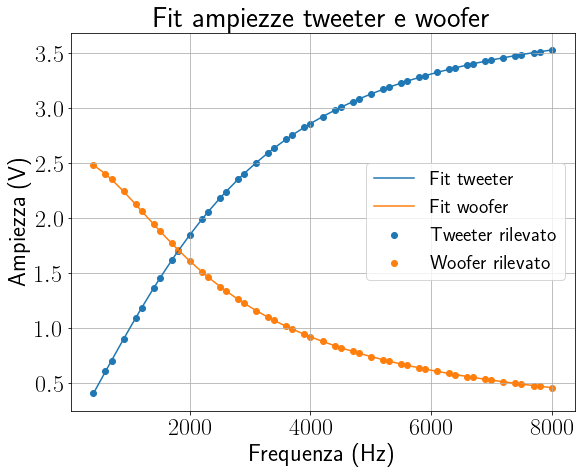

In [289]:
fig = plt.figure(figsize=figsize)

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Fit ampiezze tweeter e woofer')

axes.scatter(V_T_sweep_df['frequency'], V_T_sweep_df['amplitude'], label='Tweeter rilevato')
axes.scatter(V_W_sweep_df['frequency'], V_W_sweep_df['amplitude'], label='Woofer rilevato')

A_Ts = V_T_sweep_df['frequency'].apply(lambda f: 2*np.pi*f).apply(A_T_fit)
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Fit tweeter')

A_Ws = V_W_sweep_df['frequency'].apply(lambda f: 2*np.pi*f).apply(A_W_fit)
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Fit woofer')

axes.legend()
axes.grid()


# Match delle ampiezze

C:\Users\damia\AppData\Local\Temp/ipykernel_17760/3244909186.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axes.errorbar(float(amplitude_match_freq_val), float(match_amplitude_val), xerr=2*float(amplitude_match_freq_err_val), yerr=2*float(match_amplitude_err_val), fmt='.k', label='Crossover previsto', color='green', lw=0.8)


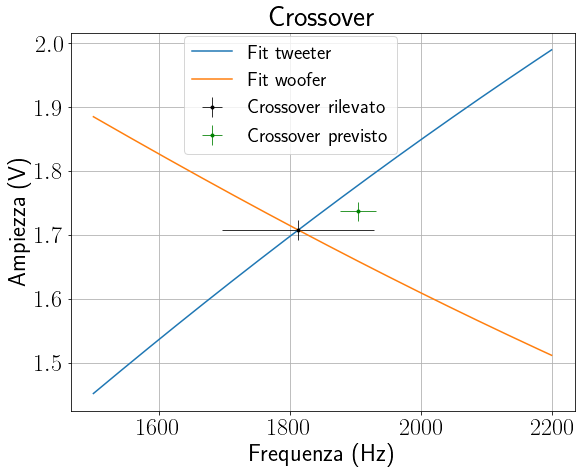

In [290]:

fig = plt.figure(figsize=figsize)

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Crossover')

fs = np.linspace(1500, 2200, 200)

axes.plot(fs, A_T_fit(2*pi*fs), label='Fit tweeter')
axes.plot(fs, A_W_fit(2*pi*fs), label='Fit woofer')
axes.errorbar(crossover_freq_fit, A_T_fit(2*pi*crossover_freq_fit), xerr=2*float(crossover_freq_err_val), yerr=2*float(match_amplitude_err_val), fmt='.k', label='Crossover rilevato', lw=0.8)
axes.errorbar(float(amplitude_match_freq_val), float(match_amplitude_val), xerr=2*float(amplitude_match_freq_err_val), yerr=2*float(match_amplitude_err_val), fmt='.k', label='Crossover previsto', color='green', lw=0.8)

axes.legend(loc=(0.225, 0.68))
axes.grid()


# Previsione teorica fase

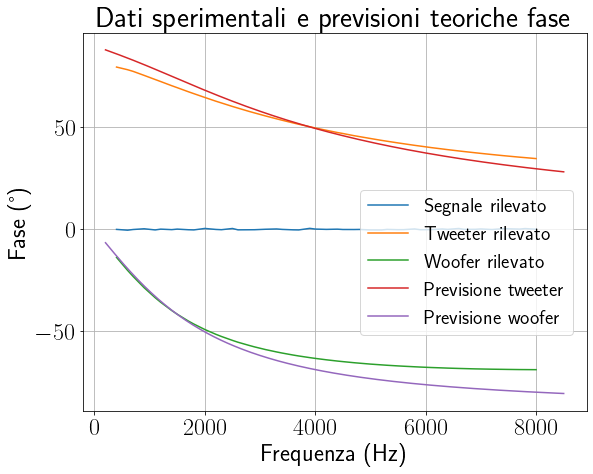

In [291]:
fig = plt.figure(figsize=figsize)

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Fase (°)')
axes.set_title('Dati sperimentali e previsioni teoriche fase')

axes.plot(V_S_sweep_df['frequency'], V_S_sweep_df['phase'], label='Segnale rilevato')
axes.plot(V_T_sweep_df['frequency'], V_T_sweep_df['phase'], label='Tweeter rilevato')
axes.plot(V_W_sweep_df['frequency'], V_W_sweep_df['phase'], label='Woofer rilevato')
#axes.plot(V_W_sweep_df['frequency'], V_T_sweep_df['phase'] + V_W_sweep_df['phase'], label='Somma delle fasi')

fs = np.linspace(200, 8500, 200)

phi_Ts = np.array([N(phi_T.subs(numerical_values).subs({w: 2*pi*x})) * 180 / pi for x in fs])
axes.plot(fs, phi_Ts, label='Previsione tweeter')

phi_Ws = np.array([N(phi_W.subs(numerical_values).subs({w: 2*pi*x})) * 180 / pi for x in fs])
axes.plot(fs, phi_Ws, label='Previsione woofer')

#axes.plot(fs, phi_Ts + phi_Ws, label='Somma previsioni')

axes.legend(loc=(0.55,0.2))
axes.grid()

# Fit fase

In [292]:
df = variable_frequency_noise_df[variable_frequency_noise_df['phase'] < -3]
lin_w = b*w+c


In [293]:
lin_w_fit, lin_w_params, _ = fit(lin_w, w, [b, c], df['frequency'], df['phase'], p0={b: 10**-3, c: -5})

par errors = 
[1.4202087744899263e-05, 0.07493212643235816]


In [298]:
lin_w_params

{b: 0.00011377163404234214, c: -5.367533065349702}

Text(0.5, 1.0, 'Andamento della fase in funzione della frequenza')

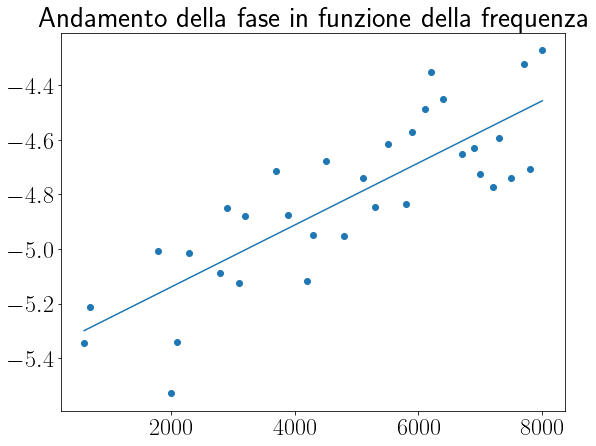

In [294]:
fig = plt.figure(figsize=figsize)

axes = fig.add_axes([0, 0, 1, 1])

axes.scatter(df['frequency'], df['phase'])
axes.plot(df['frequency'], df['frequency'].apply(lin_w_fit))
axes.set_title('Andamento della fase in funzione della frequenza')


In [295]:
lin_w_error = compute_rms(df['frequency'], df['phase'], lin_w_fit)

In [315]:
phi_T_fit, phi_T_params, _ = fit(phi_T * 180 / pi + lin_w, w, [C, L, b, c], V_T_sweep_df['frequency'].apply(lambda f: 2*pi*f), V_T_sweep_df['phase'], yerr=phase_error, xerr=frequency_error, p0=lin_w_params)

parameters =  [ 5.87560393e-08  1.01741235e-01  1.98949512e-04 -8.69542550e+00]
chi square / dof =  68.03620565979631  /  45
par errors = 
[1.800150050893362e-10, 0.002463146502022319, 1.398262538146398e-06, 0.0366879020257082]


In [314]:
phi_W_fit, phi_W_params, phi_T_par_errors = fit(phi_W * 180 / pi + lin_w, w, [C, L, b, c], V_W_sweep_df['frequency'].apply(lambda f: 2*pi*f), V_W_sweep_df['phase'], yerr=phase_error, xerr=frequency_error, p0=lin_w_params)


parameters =  [-2.00102675e-08  5.25378566e-02  1.54001284e-04 -2.32764978e-01]
chi square / dof =  9.312172598480718  /  45
par errors = 
[4.95672640620792e-10, 6.269888781354008e-05, 9.129879336841056e-07, 0.03322335643518783]


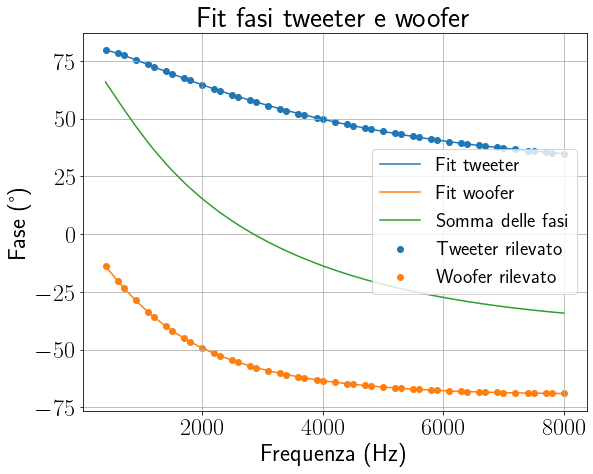

In [313]:
fig = plt.figure(figsize=figsize)

axes = fig.add_axes([0, 0, 1, 1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Fase (°)')
axes.set_title('Fit fasi tweeter e woofer')

axes.scatter(V_T_sweep_df['frequency'], V_T_sweep_df['phase'], label='Tweeter rilevato')
axes.scatter(V_W_sweep_df['frequency'], V_W_sweep_df['phase'], label='Woofer rilevato')

phi_Ts = V_T_sweep_df['frequency'].apply(lambda f: 2*np.pi*f).apply(phi_T_fit)
axes.plot(V_T_sweep_df['frequency'], phi_Ts, label='Fit tweeter')

phi_Ws = V_W_sweep_df['frequency'].apply(lambda f: 2*np.pi*f).apply(phi_W_fit)
axes.plot(V_W_sweep_df['frequency'], phi_Ws, label='Fit woofer')

diff_phis = V_T_sweep_df['frequency'].apply(lambda f: 2*np.pi*f).apply(lambda x: phi_T_fit(x) + phi_W_fit(x))
axes.plot(V_W_sweep_df['frequency'], diff_phis, label='Somma delle fasi')

axes.legend()
axes.grid()


In [ ]:
crossover_w_fit = minimize_scalar(lambda wx: (A_T_fit(wx) - A_W_fit(wx))**2, bounds=(1500*2*np.pi, 2000*2*np.pi), method='bounded')
crossover_freq_fit = crossover_w_fit.x / 2 / pi
crossover_freq_err_val = calculate_uncertainty(crossover_freq, crossover_freq_fit, uncertainties | A_W_fit_par_errors)
print('crossover dal fit (Hz) = ')
print(crossover_freq_fit, ' +/- ', crossover_freq_err_val)